# Bulk Data Overview

This notebook provides an overview of the bulk data files available in the dataset. It mainly uses the .tsv file located in this folder. The full annotated dataset with additional information is in the excel files.
This Figure creates parts of Supplementary Figure 3 of the associated publication.

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec
import re
from pathlib import Path

In [2]:
# Load the bulk data
df = pd.read_csv("Bulk_Data.tsv", sep="\t")
# Plot parameters
FONT_FAMILY = "DejaVu Sans"
FS       = 14
TICK_FS  = 12
DOT_SIZE = 20
mpl.rcParams.update({"font.family": FONT_FAMILY, "svg.fonttype": "none"})
COLOR_MIN, COLOR_MAX = "white", "red"
cmap = LinearSegmentedColormap.from_list("white_to_red", [COLOR_MIN, COLOR_MAX])

In [3]:
# for each row calculate the standard deviation of "Sample_1 - Sample_12", the standard deviation relative to mean measurement
sample_cols = [col for col in df.columns if "Sample_" in col]
# create "sample_corr" colums named "Sample_corr_{i}" that divide their respective Sample column by the sum of N_16, N_16C9 and N_17
for i in range(1, 13):
    df[f"SampleCorr_{i}"] = df[f"Sample_{i}"] / df[["N_16", "N_16C9", "N_17"]].sum(axis=1)
sample_cols = [col for col in df.columns if "SampleCorr" in col]
# # Figure 1: Boxplots of the different lipid classes
# group_cols = ["Lipid_Class", "LabelKey"]
# agg = (df.groupby(group_cols)[sample_cols]
#          .sum()
#          .reset_index())
#
# # --- Plot: per-class boxplots (one figure per class) ---
# out_dir = Path("figures")  # change to your preferred output folder
# out_dir.mkdir(parents=True, exist_ok=True)
# agg["std_dev"] = agg[sample_cols].std(axis=1)
# agg["mean"] = agg[sample_cols].mean(axis=1)
# agg["std_rel"] = agg["std_dev"] / agg["mean"]

In [4]:
# Table adjustments: Add column of lipid class and c-atoms
# Extract DG/TG/PC and carbon number
def parse_lip_class_and_carbons(name):
    m = re.match(r'^(DG|TG|PC)\s+(\d+):', name.strip())
    if not m:
        return None, None
    lip_class_map = {"DG": "DAG", "TG": "TAG", "PC": "PC"}
    lip_class = lip_class_map.get(m.group(1), m.group(1))
    carbons = int(m.group(2))
    return lip_class, carbons

df[["Lipid_Class", "C_atoms"]] = df["Name"].apply(lambda x: pd.Series(parse_lip_class_and_carbons(x)))
def label_key(row):
    return f"${row['Lipid_Class']}_\u007b({int(row['N_ul'])},{int(row['N_16'])},{int(row['N_16C9'])},{int(row['N_17'])})\u007d$"
df["LabelKey"] = df.apply(label_key, axis=1)
# Verify
print(df[["Name", "Lipid_Class", "C_atoms", "LabelKey"]].head())

        Name Lipid_Class  C_atoms           LabelKey
0  DG 30:0;Y         DAG       30  $DAG_{(1,1,0,0)}$
1  DG 32:3;Y         DAG       32  $DAG_{(1,1,0,0)}$
2  DG 32:2;Y         DAG       32  $DAG_{(1,1,0,0)}$
3  DG 32:1;Y         DAG       32  $DAG_{(1,1,0,0)}$
4  DG 32:0;Y         DAG       32  $DAG_{(1,1,0,0)}$


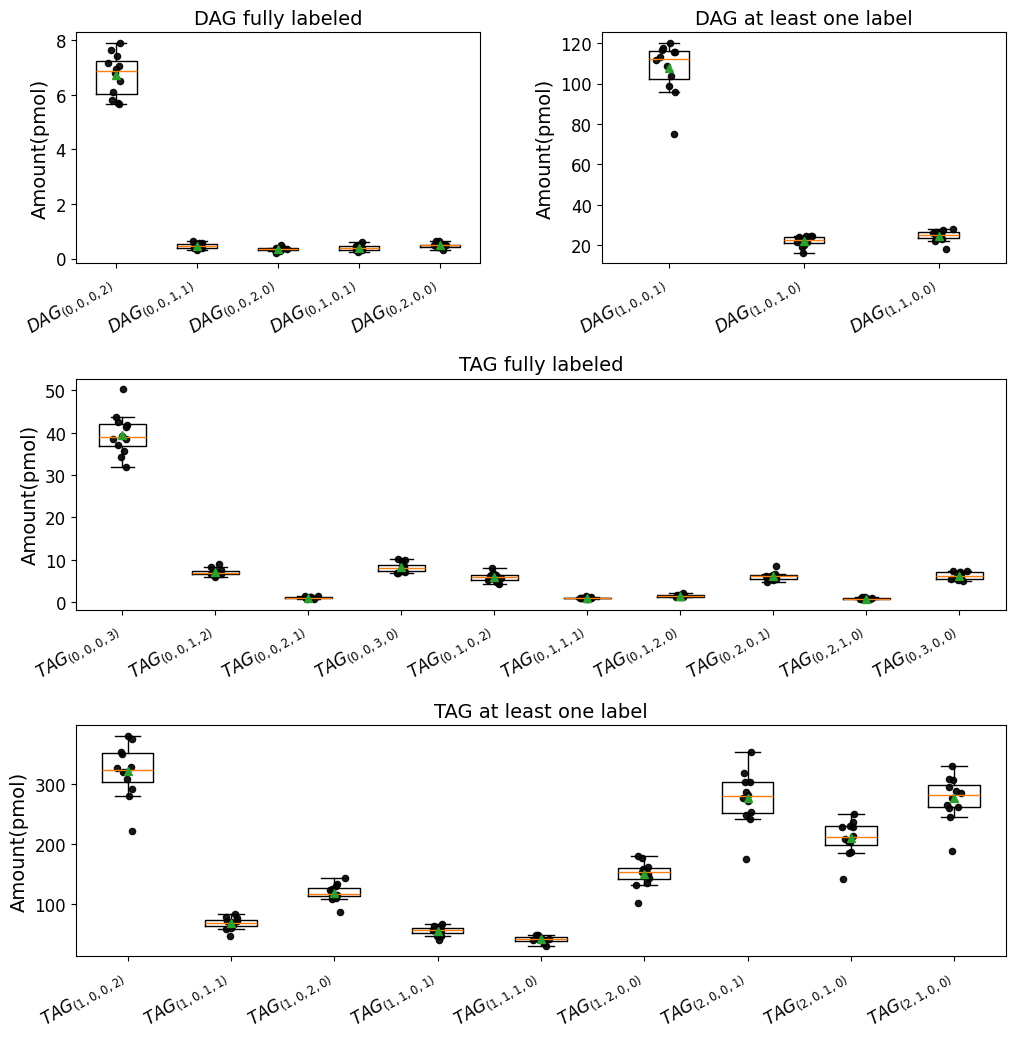

In [5]:
# Fig1 panel subplots creation
agg = (df.groupby(["Lipid_Class","LabelKey"])[sample_cols].sum().reset_index())

def has_unlabeled(labelkey: str) -> bool:
    """
    Returns True if the label key string (e.g. '$DAG_{(1,1,0,0)}$')
    has N_ul >= 1.
    """
    m = re.search(r"(\d+),(\d+),(\d+),(\d+)", labelkey)
    return bool(m and int(m.group(1)) >= 1)

def plot_combination_box(ax, sub_df, title=None):
    labelkeys = sub_df["LabelKey"].tolist()
    data = [sub_df.loc[sub_df["LabelKey"]==lk, sample_cols].values.flatten() for lk in labelkeys]
    ax.boxplot(data, tick_labels=labelkeys, showmeans=True, showfliers=False)
    rng = np.random.default_rng(42)
    for i, y in enumerate(data, start=1):
        x = rng.normal(i, 0.05, size=len(y))
        ax.scatter(x, y, s=DOT_SIZE, color="black", alpha=0.9)
    ax.tick_params(axis="both", labelsize=TICK_FS)
    if title: ax.set_title(title, fontsize=FS)
    ax.set_ylabel("Amount(pmol)", fontsize=FS)
    for lbl in ax.get_xticklabels():
        lbl.set_rotation(30); lbl.set_horizontalalignment("right")

dag = agg[agg["Lipid_Class"]=="DAG"]
tag = agg[agg["Lipid_Class"]=="TAG"]
dag_u0 = dag[~dag["LabelKey"].apply(has_unlabeled)]
dag_u1 = dag[dag["LabelKey"].apply(has_unlabeled)]
tag_u0 = tag[~tag["LabelKey"].apply(has_unlabeled)]
tag_u1 = tag[tag["LabelKey"].apply(has_unlabeled)]

fig = plt.figure(figsize=(12, 12))
gs = GridSpec(nrows=3, ncols=2, height_ratios=[1,1,1], width_ratios=[1,1], hspace=0.5, wspace=0.3)

axA = fig.add_subplot(gs[0,0]); plot_combination_box(axA, dag_u0, "DAG fully labeled")
axB = fig.add_subplot(gs[0,1]); plot_combination_box(axB, dag_u1, "DAG at least one label")
axC = fig.add_subplot(gs[1,:]); plot_combination_box(axC, tag_u0, "TAG fully labeled")
axD = fig.add_subplot(gs[2,:]); plot_combination_box(axD, tag_u1, "TAG at least one label")

plt.show()

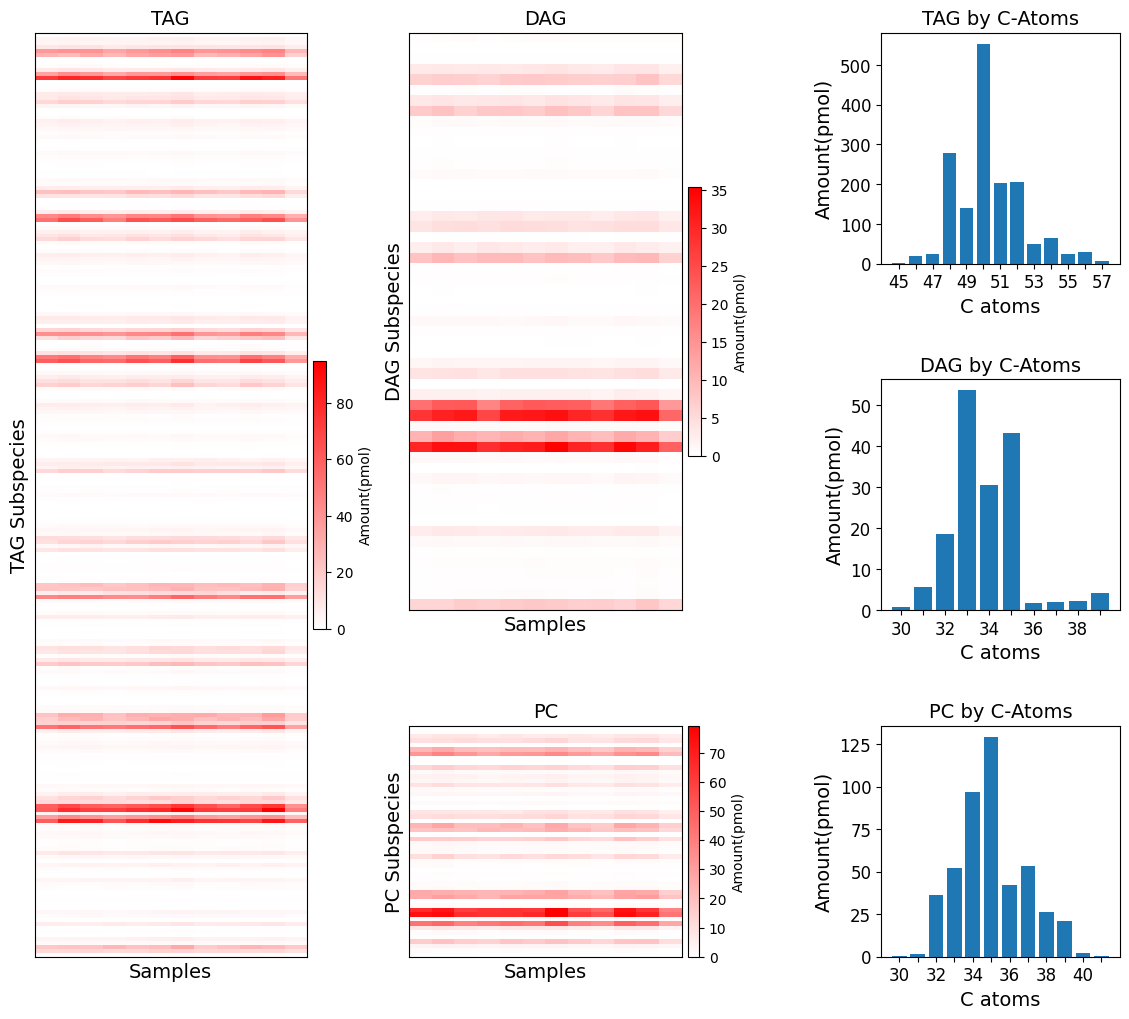

In [6]:
# Fig2 panel assembly
def plot_heatmap(ax, sub_df, cls, title):
    if sub_df.empty:
        ax.text(0.5, 0.5, "No data", ha="center", va="center", fontsize=FS)
        ax.set_xticks([]); ax.set_yticks([])
        ax.set_title(title, fontsize=FS)
        return None
    mat = sub_df.set_index("Name")[sample_cols]
    vmin, vmax = 0.0, float(np.nanmax(mat.values)) if np.isfinite(mat.values).any() else 1.0
    im = ax.imshow(mat.values, aspect="auto", interpolation="nearest", cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("Samples", fontsize=FS); ax.set_ylabel(f"{cls} Subspecies", fontsize=FS)
    ax.set_title(title, fontsize=FS)
    return im

def plot_chainlength(ax, sub_df, cls, title):
    if sub_df.empty:
        ax.text(0.5, 0.5, "No data", ha="center", va="center", fontsize=FS)
        ax.set_xticks([]); ax.set_yticks([])
        ax.set_title(title, fontsize=FS); return
    totals = sub_df.assign(total=sub_df[sample_cols].mean(axis=1)).groupby("C_atoms", as_index=False)["total"].sum().sort_values("C_atoms")
    ax.bar(totals["C_atoms"].astype(str), totals["total"].values)
    ax.set_xlabel("C atoms", fontsize=FS)
    ax.set_ylabel("Amount(pmol)", fontsize=FS)
    ax.set_title(title, fontsize=FS)
    # Halve the number of x tick labels by hiding every second label
    for i, lbl in enumerate(ax.get_xticklabels()):
        if i % 2 == 1:
            lbl.set_visible(False)
    ax.tick_params(axis="both", labelsize=TICK_FS)

tag = df[df["Lipid_Class"]=="TAG"]
dag = df[df["Lipid_Class"]=="DAG"]
pc  = df[df["Lipid_Class"]=="PC"]

fig = plt.figure(figsize=(14, 12))
gs = GridSpec(nrows=3, ncols=4, width_ratios=[1.1, 1.1, 0.05, 0.9], height_ratios=[1,1,1], wspace=0.4, hspace=0.5)

ax_hm_tag = fig.add_subplot(gs[:, 0])
im_tag = plot_heatmap(ax_hm_tag, tag, "TAG", "TAG")
if im_tag is not None:
    fig.colorbar(im_tag, ax=ax_hm_tag, orientation="vertical", fraction=0.046, pad=0.02, label="Amount(pmol)")

ax_hm_dag = fig.add_subplot(gs[0:2, 1])
im_dag = plot_heatmap(ax_hm_dag, dag, "DAG", "DAG")
if im_dag is not None:
    fig.colorbar(im_dag, ax=ax_hm_dag, orientation="vertical", fraction=0.046, pad=0.02, label="Amount(pmol)")

ax_hm_pc  = fig.add_subplot(gs[2, 1])
im_pc = plot_heatmap(ax_hm_pc, pc, "PC", "PC")
if im_pc is not None:
    fig.colorbar(im_pc, ax=ax_hm_pc, orientation="vertical", fraction=0.046, pad=0.02, label="Amount(pmol)")

ax_cl_tag = fig.add_subplot(gs[0, 3]); plot_chainlength(ax_cl_tag, tag, "TAG", "TAG by C-Atoms")
ax_cl_dag = fig.add_subplot(gs[1, 3]); plot_chainlength(ax_cl_dag, dag, "DAG", "DAG by C-Atoms")
ax_cl_pc  = fig.add_subplot(gs[2, 3]); plot_chainlength(ax_cl_pc,  pc,  "PC",  "PC by C-Atoms")

plt.show()